## Import packages

In [50]:
# If using Google Colab, uncomment the following line
# !pip install rasterio

import sys
print(sys.version)  # Print Python version in use

import numpy as np                                      # Array operations
import matplotlib.pyplot as plt                         # Plotting library
import torch                                            # Main PyTorch library
import torch.optim as optim                             # Optimization algorithms
import torch.nn as nn                                   # Neural network modules
import os                                               # Operating system utilities
import pandas as pd                                     # Data manipulation
import rasterio                                         # Geospatial raster data

from datetime import datetime, timedelta                # Date/time utilities
from rasterio.plot import show                          # Plot raster data	

import deepSSF_model                                    # Import the deepSSF model
import deepSSF_utils                                    # Import the deepSSF utilities

# Get today's date
today_date = datetime.today().strftime('%Y-%m-%d')

3.12.5 | packaged by Anaconda, Inc. | (main, Sep 12 2024, 18:18:29) [MSC v.1929 64 bit (AMD64)]


### If using Google Colab, uncomment the following lines

The file directories will also need to be changed to match the location of the files in your Google Drive.

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

## Import the GPS data

We only use this for selecting a spatial extent for the area we want to predict over.

In [28]:
# select the id of that data that the model was trained on
buffalo_id = 2005
n_samples = 10297 # 2005 has 10297 samples

# Specify the path to your CSV file
csv_file_path = f'../buffalo_local_data_id/buffalo_{buffalo_id}_data_df_lag_1hr_n{n_samples}.csv'

# Read the CSV file into a DataFrame
buffalo_df = pd.read_csv(csv_file_path)

# Display the first few rows of the DataFrame
print(buffalo_df.head())

# Lag the values in column 'A' by one index
buffalo_df['bearing_tm1'] = buffalo_df['bearing'].shift(1)
# Pad the missing value with a specified value, e.g., 0
buffalo_df['bearing_tm1'] = buffalo_df['bearing_tm1'].fillna(0)

# Display the first few rows of the DataFrame
print(buffalo_df.head())

             x_            y_                    t_    id           x1_  \
0  41969.310875 -1.435671e+06  2018-07-25T01:04:23Z  2005  41969.310875   
1  41921.521939 -1.435654e+06  2018-07-25T02:04:39Z  2005  41921.521939   
2  41779.439594 -1.435601e+06  2018-07-25T03:04:17Z  2005  41779.439594   
3  41841.203272 -1.435635e+06  2018-07-25T04:04:39Z  2005  41841.203272   
4  41655.463332 -1.435604e+06  2018-07-25T05:04:27Z  2005  41655.463332   

            y1_           x2_           y2_     x2_cent    y2_cent  ...  \
0 -1.435671e+06  41921.521939 -1.435654e+06  -47.788936  16.857110  ...   
1 -1.435654e+06  41779.439594 -1.435601e+06 -142.082345  53.568427  ...   
2 -1.435601e+06  41841.203272 -1.435635e+06   61.763677 -34.322938  ...   
3 -1.435635e+06  41655.463332 -1.435604e+06 -185.739939  31.003534  ...   
4 -1.435604e+06  41618.651923 -1.435608e+06  -36.811409  -4.438037  ...   

         ta    cos_ta         x_min         x_max         y_min         y_max  \
0  1.367942  0.20

# Importing spatial data

Instead of importing the stacks of local layers (one for each step), here we want to import the spatial covariates for the extent we want to simulate over. We use an extent that covers all of the observed locations, which refer to as the 'landscape'.

## NDVI

We have monthly NDVI layers for 2018 and 2019, which we import as a stack. The files don't import with a time component, so we will use a function further down that indexes them correctly.

In [29]:
# for monthly NDVI
file_path = '../mapping/cropped rasters/ndvi_monthly.tif'

# read the raster file
with rasterio.open(file_path) as src:
    # Read the raster band as separate variable
    ndvi_landscape = src.read([i for i in range(1, src.count + 1)])
    # Get the metadata of the raster
    ndvi_meta = src.meta
    raster_transform = src.transform

    # Print the metadata to check for time component
    print("Metadata:", ndvi_meta)

    # Check for specific time-related metadata
    if 'TIFFTAG_DATETIME' in src.tags():
        print("Time component found:", src.tags()['TIFFTAG_DATETIME'])
    else:
        print("No explicit time component found in metadata.")

# the rasters don't contain a time component, so we will use a function later to index the layers correctly

Metadata: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 2400, 'height': 2280, 'count': 24, 'crs': CRS.from_wkt('LOCAL_CS["GDA94 / Geoscience Australia Lambert",UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'), 'transform': Affine(25.0, 0.0, 0.0,
       0.0, -25.0, -1406000.0)}
No explicit time component found in metadata.


### Prepare the NDVI data

There are a few things we need to do to prepare the landscape layers. 

First, we need to ensure that there are no NA values in the data. For NDVI we will replace any NA values with -1 (which denotes water), as in our case that is typically why they were set to NA. 

Secondly, the model expects the covariates to on *the same scale as the training data*. We will therefore scale the NDVI data using the same max and min scaling parameters as the training data. To get these, there are some min and max print statements in the `deepSSF_train.ipynb` script. When we plot the NDVI data below we will see that the values will no longer range from 0 to 1, which is because there are values in the landscape layers that are outside of the range of the training data.

NDVI metadata:
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 2400, 'height': 2280, 'count': 24, 'crs': CRS.from_wkt('LOCAL_CS["GDA94 / Geoscience Australia Lambert",UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'), 'transform': Affine(25.0, 0.0, 0.0,
       0.0, -25.0, -1406000.0)}


Affine transformation parameters:
| 25.00, 0.00, 0.00|
| 0.00,-25.00,-1406000.00|
| 0.00, 0.00, 1.00|


Shape of the raster:
(24, 2280, 2400)


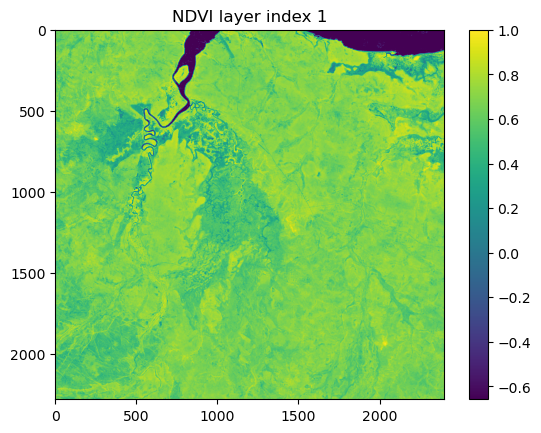

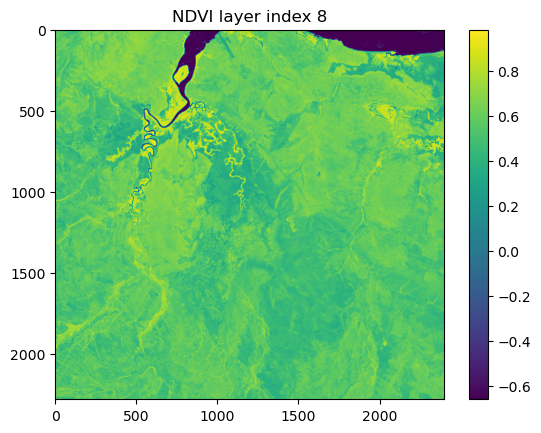

In [30]:
# Check the coordinate reference system
print("NDVI metadata:")
print(ndvi_meta)
print("\n")

# Have a look at the affine transformation parameters that are used to convert pixel 
# coordinates to geographic coordinates and vice versa
print("Affine transformation parameters:")
print(raster_transform)
print("\n")

# Check the shape (layers, row, columns) of the raster
print("Shape of the raster:")
print(ndvi_landscape.shape)

# Replace NaNs in the original array with -1, which represents water
ndvi_landscape = np.nan_to_num(ndvi_landscape, nan=-1.0)

# from the stack of local layers (training data)
ndvi_max = 0.8220
ndvi_min = -0.2772

# Convert the numpy array to a PyTorch tensor
ndvi_landscape_tens = torch.from_numpy(ndvi_landscape)

# Normalizing the data
ndvi_landscape_norm = (ndvi_landscape_tens - ndvi_min) / (ndvi_max - ndvi_min)

# Show two example layers of the scaled NDVI data
layer_index = 1
plt.imshow(ndvi_landscape_norm[layer_index,:,:].numpy())
plt.colorbar()  
plt.title(f'NDVI layer index {layer_index}')
plt.show()

layer_index = 8
plt.imshow(ndvi_landscape_norm[layer_index,:,:].numpy())
plt.colorbar()  
plt.title(f'NDVI layer index {layer_index}')
plt.show()

## Canopy cover

Canopy cover is just a single static layer.

In [31]:
# Path to the canopy cover raster file
file_path = '../mapping/cropped rasters/canopy_cover.tif'

# read the raster file
with rasterio.open(file_path) as src:
    # Read the raster band as separate variable
    canopy_landscape = src.read(1)
    # Get the metadata of the raster
    canopy_meta = src.meta

### Prepare the canopy cover data

As with the NDVI data, we need to ensure that there are no NA values in the data. 

As the canopy cover values in the landscape layer are within the same range as the training data, we see that the values range from 0 to 1.

Canopy metadata:
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -3.3999999521443642e+38, 'width': 2400, 'height': 2280, 'count': 1, 'crs': CRS.from_wkt('LOCAL_CS["GDA94 / Geoscience Australia Lambert",UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'), 'transform': Affine(25.0, 0.0, 0.0,
       0.0, -25.0, -1406000.0)}


Shape of canopy raster:
(2280, 2400)


Number of NA values in the canopy raster:
0


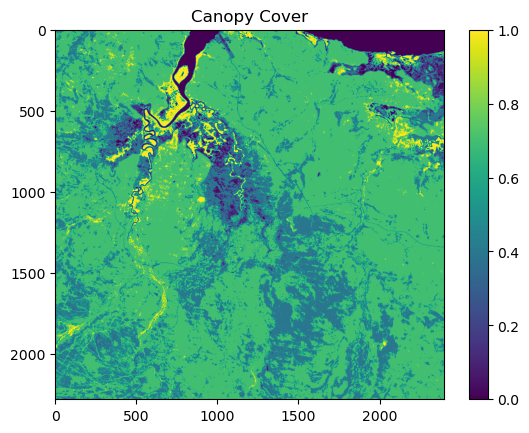

In [32]:
# Check the canopy metadata:
print("Canopy metadata:")
print(canopy_meta)
print("\n")

# Check the shape (rows, columns) of the canopy raster:
print("Shape of canopy raster:")
print(canopy_landscape.shape)
print("\n")

# Check for NA values in the canopy raster:
print("Number of NA values in the canopy raster:")
print(np.isnan(canopy_landscape).sum())

# Define the maximum and minimum canopy values from the stack of local layers:
canopy_max = 82.5000
canopy_min = 0.0

# Convert the canopy data from a NumPy array to a PyTorch tensor:
canopy_landscape_tens = torch.from_numpy(canopy_landscape)

# Normalise the canopy data:
canopy_landscape_norm = (canopy_landscape_tens - canopy_min) / (canopy_max - canopy_min)

# Visualise the normalised canopy cover:
plt.imshow(canopy_landscape_norm.numpy())
plt.colorbar()
plt.title('Canopy Cover')
plt.show()


## Herbaceous vegetation

In [33]:
# Path to the herbaceous vegetation raster file
file_path = '../mapping/cropped rasters/veg_herby.tif'

# read the raster file
with rasterio.open(file_path) as src:
    # Read the raster band as separate variable
    herby_landscape = src.read(1)
    # Get the metadata of the raster
    herby_meta = src.meta

Herbaceous metadata:
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -3.3999999521443642e+38, 'width': 2400, 'height': 2280, 'count': 1, 'crs': CRS.from_wkt('LOCAL_CS["GDA94 / Geoscience Australia Lambert",UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'), 'transform': Affine(25.0, 0.0, 0.0,
       0.0, -25.0, -1406000.0)}


Shape of herbaceous raster:
(2280, 2400)


Number of NA values in the herbaceous vegetation raster:
0


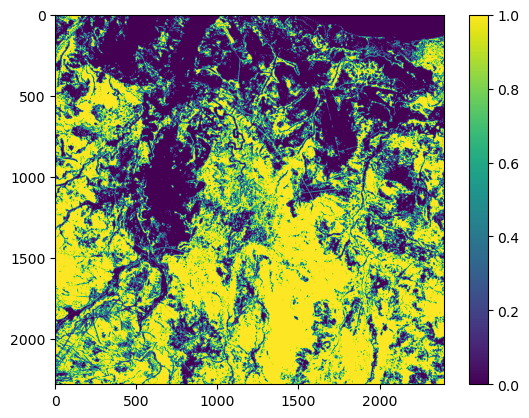

In [34]:
# Check the herbaceous metadata:
print("Herbaceous metadata:")
print(herby_meta)
print("\n")

# Check the shape (rows, columns) of the herbaceous raster:
print("Shape of herbaceous raster:")
print(herby_landscape.shape)
print("\n")

# Check for NA values in the herby raster:
print("Number of NA values in the herbaceous vegetation raster:")
print(np.isnan(herby_landscape).sum())

# Define the maximum and minimum herbaceous values from the stack of local layers:
herby_max = 1.0
herby_min = 0.0

# Convert the herbaceous data from a NumPy array to a PyTorch tensor:
herby_landscape_tens = torch.from_numpy(herby_landscape)

# Normalize the herbaceous data:
herby_landscape_norm = (herby_landscape_tens - herby_min) / (herby_max - herby_min)

# Visualize the normalised herbaceous cover:
plt.imshow(herby_landscape_norm.numpy())
plt.colorbar()
plt.show()


## Slope

In [35]:
# Path to the slope raster file
file_path = '../mapping/cropped rasters/slope.tif'

# read the raster file
with rasterio.open(file_path) as src:
    # Read the raster band as separate variable
    slope_landscape = src.read(1)
    # Get the metadata of the raster
    slope_meta = src.meta

Slope metadata:
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 2400, 'height': 2280, 'count': 1, 'crs': CRS.from_wkt('LOCAL_CS["GDA94 / Geoscience Australia Lambert",UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'), 'transform': Affine(25.0, 0.0, 0.0,
       0.0, -25.0, -1406000.0)}


Shape of slope landscape raster:
(2280, 2400)


Number of NA values in the slope raster:
9356


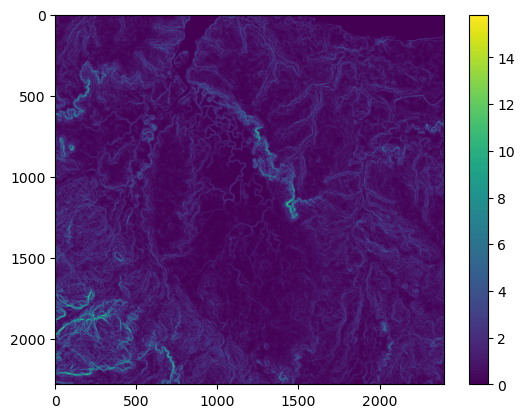

In [36]:
# Check the slope metadata:
print("Slope metadata:")
print(slope_meta)
print("\n")

# Check the shape (rows, columns) of the slope landscape raster:
print("Shape of slope landscape raster:")
print(slope_landscape.shape)
print("\n")

# Check for NA values in the slope raster:
print("Number of NA values in the slope raster:")
print(np.isnan(slope_landscape).sum())

# Replace NaNs in the slope array with 0.0:
slope_landscape = np.nan_to_num(slope_landscape, nan=0.0)

# Define the maximum and minimum slope values from the stack of local layers:
slope_max = 12.2981
slope_min = 0.0006

# Convert the slope landscape data from a NumPy array to a PyTorch tensor:
slope_landscape_tens = torch.from_numpy(slope_landscape)

# Normalize the slope landscape data:
slope_landscape_norm = (slope_landscape_tens - slope_min) / (slope_max - slope_min)

# Visualize the slope landscape (note: displaying the original tensor, not the normalised data):
plt.imshow(slope_landscape_tens.numpy())
plt.colorbar()
plt.show()


### Convert between numpy array and raster

To check that we can go back and forth between numpy arrays (with pixel coordinates) and rasters (with geographic coordinates), we will convert the slope numpy array to a raster. 

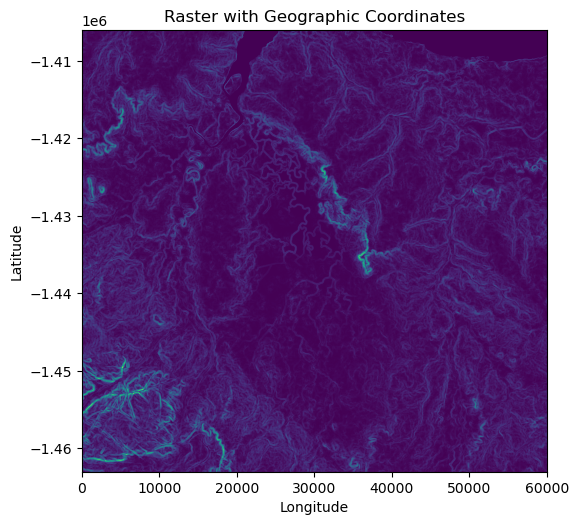

In [37]:
# Create a figure and axis with matplotlib
fig, ax = plt.subplots(figsize=(6, 6))

# Convert the slope_landcape (numpy array) to a raster and plot with the rasterio library
rasterio.plot.show(slope_landscape, transform=raster_transform, ax=ax, cmap='viridis')

# Set the title and labels
ax.set_title('Raster with Geographic Coordinates')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Show the plot
plt.show()

# Subset function (with padding)

Now that we have our landscape layers imported, we need a way to crop out the local layers that can be fed into the deepSSF model as covariates.

We will use the same subset function as in the simulation script, which we stored in the `deepSSF_utils.py` script. This function will take the landscape layers and a set of coordinates, and return the local layers for those coordinates.

This function also has padding for if the simulated individual was to go off the edge of the landscape, which we retain here (although we won't need that functionality).

In [38]:
subset_raster_with_padding_torch = deepSSF_utils.subset_raster_with_padding_torch

### Testing the subset function

Use the subset function to crop out the local layers for all covariates. Try different locations using the x and y coordinates, which are in geographic coordinates (x = easting/longitude, y = northing/latitude).

Text(0.5, 1.0, 'Slope Subset')

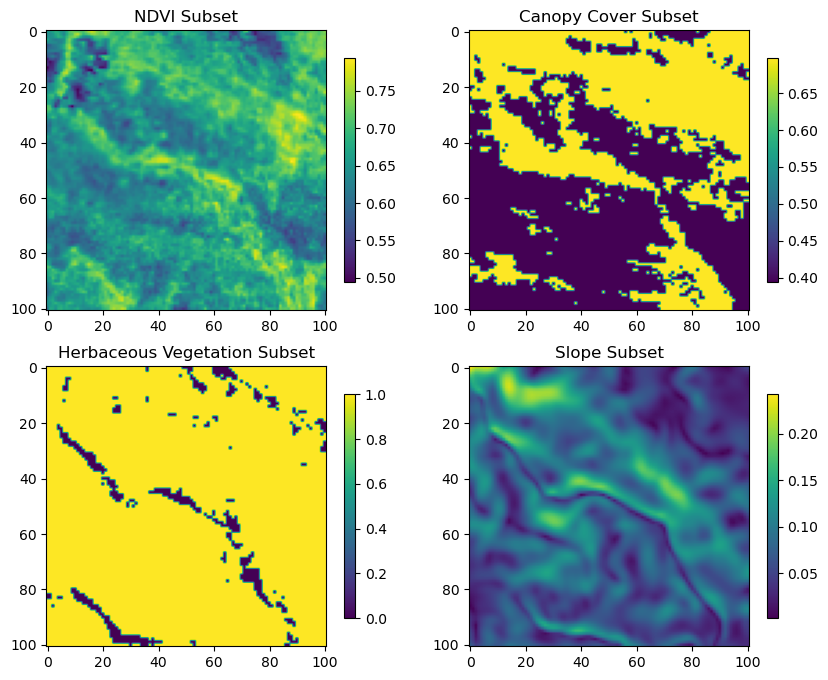

In [43]:
# Pick a location (x, y) from the buffalo DataFrame
x = buffalo_df['x1_'].iloc[0]
y = buffalo_df['y1_'].iloc[0]

# Define the size of the window to extract
window_size = 101  

# Select the NDVI layer index
which_ndvi = 1  

# Extract subsets from various raster layers using the custom function.
# Each call centres the window at the specified (x, y) location and applies padding where necessary.
ndvi_subset, origin_x, origin_y = subset_raster_with_padding_torch(ndvi_landscape_norm[which_ndvi, :, :], 
                                                                   x, y, window_size, raster_transform)
canopy_subset, origin_x, origin_y = subset_raster_with_padding_torch(canopy_landscape_norm, 
                                                                     x, y, window_size, raster_transform)
herby_subset, origin_x, origin_y = subset_raster_with_padding_torch(herby_landscape_norm, 
                                                                    x, y, window_size, raster_transform)
slope_subset, origin_x, origin_y = subset_raster_with_padding_torch(slope_landscape_norm, 
                                                                    x, y, window_size, raster_transform)

# Create a 2x2 grid of subplots with a fixed figure size.
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# Plot the NDVI subset.
im0 = axs[0, 0].imshow(ndvi_subset.numpy(), cmap='viridis')
fig.colorbar(im0, ax=axs[0, 0], shrink=0.8)
axs[0, 0].set_title('NDVI Subset')

# Plot the Canopy Cover subset.
im1 = axs[0, 1].imshow(canopy_subset.numpy(), cmap='viridis')
fig.colorbar(im1, ax=axs[0, 1], shrink=0.8)
axs[0, 1].set_title('Canopy Cover Subset')

# Plot the Herbaceous Vegetation subset.
im2 = axs[1, 0].imshow(herby_subset.numpy(), cmap='viridis')
fig.colorbar(im2, ax=axs[1, 0], shrink=0.8)
axs[1, 0].set_title('Herbaceous Vegetation Subset')

# Plot the Slope subset.
im3 = axs[1, 1].imshow(slope_subset.numpy(), cmap='viridis')
fig.colorbar(im3, ax=axs[1, 1], shrink=0.8)
axs[1, 1].set_title('Slope Subset')

# Load the model

## Set the device for the model

In [44]:
# run on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"Using {device} device")

Using cpu device


## Define the parameters for the model

Here we enter the specific parameter values and hyperparameters for the model. 
These are the values that will be used to instantiate the model.

In [45]:
# Define the parameters for the model
params_dict = {"batch_size": 32, #number of samples in each batch
               "image_dim": 101, #number of pixels along the edge of each local patch/image
               "pixel_size": 25, #number of metres along the edge of a pixel
               "dim_in_nonspatial_to_grid": 4, #the number of scalar predictors that are converted to a grid and appended to the spatial features
               "dense_dim_in_nonspatial": 4, #change this to however many other scalar predictors you have (bearing, velocity etc)
               "dense_dim_hidden": 128, #number of nodes in the hidden layers
               "dense_dim_out": 128, #number of nodes in the output of the fully connected block (FCN)
               "dense_dim_in_all": 2500,# + 128, #number of inputs entering the fully connected block once the nonspatial features have been concatenated to the spatial features
               "input_channels": 4 + 4, #number of spatial layers in each image + number of scalar layers that are converted to a grid
               "output_channels": 4, #number of filters to learn
               "kernel_size": 3, #the size of the 2D moving windows / kernels that are being learned
               "stride": 1, #the stride used when applying the kernel.  This reduces the dimension of the output if set to greater than 1
               "kernel_size_mp": 2, #the size of the kernel that is used in max pooling operations
               "stride_mp": 2, #the stride that is used in max pooling operations
               "padding": 1, #the amount of padding to apply to images prior to applying the 2D convolution
               "num_movement_params": 12, #number of parameters used to parameterise the movement kernel
               "dropout": 0.1, #the proportion of nodes that are dropped out in the dropout layers
               "device": device
               }

As described in the `deepSSF_train.ipynb` script, we saved the model definition into a file named `deepSSF_model.py`. We can instantiate the model by importing the file (which was done when importing other packages) and calling the classes parameter dictionary from that script.

In [46]:
params = deepSSF_model.ModelParams(params_dict)
model = deepSSF_model.ConvJointModel(params).to(device)
print(model)

ConvJointModel(
  (scalar_grid_output): Scalar_to_Grid_Block()
  (conv_habitat): Conv2d_block_spatial(
    (conv2d): Sequential(
      (0): Conv2d(8, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
      (4): Conv2d(4, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
  )
  (conv_movement): Conv2d_block_toFC(
    (conv2d): Sequential(
      (0): Conv2d(8, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): ReLU()
      (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Flatten(start_dim=1, end_dim=-1)
    )
  )
  (fcn_movement_all): FCN_block_all_movement(
    (ffn): Sequential(
      (0): Linear(in_features=2500, out_features=128, b

## Load the model weights

In [51]:
# # load the model weights
# print(model.state_dict())
model.load_state_dict(torch.load(f'model_checkpoints/checkpoint_CNN_buffalo2005_2025-02-04.pt', 
                                 map_location=torch.device('cpu'),
                                 weights_only=True))
# print(model.state_dict())
# model.eval()

<All keys matched successfully>

# Setup simulation parameters

To get the simulation running we need a few extra functions. 

Firstly, we need to index the NDVI layers correctly, based on the time of the simulated location. We'll do this by creating a function that takes day of the year of the simulated location and returns the correct index for the NDVI layers.

Recall that Python indexes from 0, so when the month_index is equal to 2 for instance, this will index the third layer, which is for March.

In [ ]:
# Create a mapping from day of the year to month index
def day_to_month_index(day_of_year):
    # Calculate the year and the day within that year
    base_date = datetime(2018, 1, 1) # base date for the calculation, which is when the NDVI layers start
    date = base_date + timedelta(days=int(day_of_year) - 1)
    year_diff = date.year - base_date.year
    month_index = (date.month - 1) + (year_diff * 12)  # month index (0-based, accounting for year change)
    return month_index

yday = 70 # day of the year, which is March 11th
month_index = day_to_month_index(yday)
print(month_index)

2


# Next-step probability values

We can now calculate the next-step probabilities for each observed step.

In [ ]:
# To select a subset of samples to test the function
# test_data = buffalo_df.iloc[0:10]

# To select all of the data
test_data = buffalo_df

# Store the number of samples
n = len(test_data)

# create empty vectors to store the predicted probabilities
habitat_probs = np.repeat(0., len(buffalo_df))
move_probs = np.repeat(0., len(buffalo_df))
next_step_probs = np.repeat(0., len(buffalo_df))

# start at 1 so the bearing at t - 1 is available
for i in range(1, n):
  
  sample_tm1 = test_data.iloc[i-1] # get the step at t - 1 for the bearing of the approaching step
  sample = test_data.iloc[i]

  # current location (x1, y1)
  x = sample['x1_']
  y = sample['y1_']

  # Convert geographic coordinates to pixel coordinates
  px, py = ~raster_transform * (x, y)

  # next step location (x2, y2)
  x2 = sample['x2_']
  y2 = sample['y2_']

  # Convert geographic coordinates to pixel coordinates
  px2, py2 = ~raster_transform * (x2, y2)

  # The difference in x and y coordinates
  d_x = x2 - x
  d_y = y2 - y
  # print('d_x and d_y are ', d_x, d_y) # Debugging
  
  # Temporal covariates
  hour_t2_sin = sample['hour_t2_sin']
  hour_t2_cos = sample['hour_t2_cos']
  yday_t2_sin = sample['yday_t2_sin']
  yday_t2_cos = sample['yday_t2_cos']

  # Bearing of PREVIOUS step (t - 1)
  bearing = sample_tm1['bearing']

  # Day of the year
  yday = sample['yday_t2']


  month_index = day_to_month_index(yday)
  # print(month_index)

  ndvi_subset, origin_x, origin_y = subset_raster_with_padding_torch(ndvi_global_norm[month_index,:,:], x, y, window_size, raster_transform)
  canopy_subset, origin_x, origin_y = subset_raster_with_padding_torch(canopy_global_norm, x, y, window_size, raster_transform)
  herby_subset, origin_x, origin_y = subset_raster_with_padding_torch(herby_global_norm, x, y, window_size, raster_transform)
  slope_subset, origin_x, origin_y = subset_raster_with_padding_torch(slope_global_norm, x, y, window_size, raster_transform)

  # print('origin_x and origin_y are ', origin_x, origin_y)

  px2_subset = px2 - origin_x
  py2_subset = py2 - origin_y
  # print('delta origin_x and origin_y are ', px2_subset, py2_subset)
  # print('delta origin_x and origin_y are ', int(px2_subset), int(py2_subset))

  # Extract the value of the covariates at the location of x2, y2
  value = ndvi_subset.detach().cpu().numpy()[(int(py2_subset), int(px2_subset))]

  # # from the stack of local layers
  # ndvi_max = 0.8220
  # ndvi_min = -0.2772
  # # return to natural scale
  # value_natural = value * (ndvi_max - ndvi_min) + ndvi_min

  # print('Value natural scale = ', value_natural)
  

  # # Plot the subset covariates
  # fig_covs, axs_covs = plt.subplots(2, 2, figsize=(10, 10))

  # # NDVI
  # axs_covs[0, 0].imshow(ndvi_subset.numpy(), cmap='viridis')
  # axs_covs[0, 0].set_title('NDVI')
  # fig_covs.colorbar(axs_covs[0, 0].imshow(ndvi_subset.numpy(), cmap='viridis'), ax=axs_covs[0, 0], shrink=0.7)
  # # Canopy Cover
  # axs_covs[0, 1].imshow(canopy_subset.numpy(), cmap='viridis')
  # axs_covs[0, 1].set_title('Canopy Cover')
  # fig_covs.colorbar(axs_covs[0, 1].imshow(canopy_subset.numpy(), cmap='viridis'), ax=axs_covs[0, 1], shrink=0.7)
  # # Herbaceous Vegetation
  # axs_covs[1, 0].imshow(herby_subset.numpy(), cmap='viridis')
  # axs_covs[1, 0].set_title('Herbaceous Vegetation')
  # fig_covs.colorbar(axs_covs[1, 0].imshow(herby_subset.numpy(), cmap='viridis'), ax=axs_covs[1, 0], shrink=0.7)
  # # Slope
  # axs_covs[1, 1].imshow(slope_subset.numpy(), cmap='viridis')
  # axs_covs[1, 1].set_title('Slope')  
  # fig_covs.colorbar(axs_covs[1, 1].imshow(slope_subset.numpy(), cmap='viridis'), ax=axs_covs[1, 1], shrink=0.7)


  # Stack the channels along a new axis; here, 1 is commonly used for channel axis in PyTorch
  x1 = torch.stack([ndvi_subset, canopy_subset, herby_subset, slope_subset], dim=0)
  x1 = x1.unsqueeze(0)
  # print(x1.shape)

  # Convert lists to PyTorch tensors
  hour_t2_sin_tensor = torch.tensor(hour_t2_sin).float()
  hour_t2_cos_tensor = torch.tensor(hour_t2_cos).float()
  yday_t2_sin_tensor = torch.tensor(yday_t2_sin).float()
  yday_t2_cos_tensor = torch.tensor(yday_t2_cos).float()

  # Stack tensors column-wise
  x2 = torch.stack((hour_t2_sin_tensor.unsqueeze(0), 
                    hour_t2_cos_tensor.unsqueeze(0), 
                    yday_t2_sin_tensor.unsqueeze(0), 
                    yday_t2_cos_tensor.unsqueeze(0)),  
                    dim=1)
  # print(x2)
  # print(x2.shape)

  # put bearing in the correct dimension (batch_size, 1)
  bearing = torch.tensor(bearing).float().unsqueeze(0).unsqueeze(0)
  # print(bearing)
  # print(bearing.shape)

  test = model((x1, x2, bearing))

  # plot the results of the habitat density as an image
  hab_density = test.detach().cpu().numpy()[0,:,:,0]
  hab_density_exp = np.exp(hab_density)
  # print(np.sum(hab_density_exp))

  # Store the probability of habitat selection at the location of x2, y2
  habitat_probs[i] = hab_density_exp[(int(py2_subset), int(px2_subset))]
  # print('Habitat probability value = ', habitat_probs[i])

  # Create the mask for x and y coordinates
  x_mask = np.ones_like(hab_density)
  y_mask = np.ones_like(hab_density)

  # mask out cells on the edges that affect the colour scale
  x_mask[:, :3] = -np.inf
  x_mask[:, 98:] = -np.inf
  y_mask[:3, :] = -np.inf
  y_mask[98:, :] = -np.inf

  hab_density_mask = hab_density * x_mask * y_mask
  hab_density_exp_mask = hab_density_exp * x_mask * y_mask

  # # plot the results of the habitat density as an image - in log scale
  # plt.imshow(hab_density_mask)
  # plt.colorbar()
  # plt.show()

  # # plot the results of the habitat density as an image - as probabilities
  # plt.imshow(hab_density_exp_mask)
  # plt.colorbar()
  # plt.show()

  # movement probability
  move_density = test.detach().cpu().numpy()[0,:,:,1]
  move_density_exp = np.exp(move_density)
  # print(np.sum(move_density_exp))

  # Store the probability of movement at the location of x2, y2
  move_probs[i] = move_density_exp[(int(py2_subset), int(px2_subset))]
  # print('Movement probability value = ', move_probs[i])

  move_density_mask = move_density * x_mask * y_mask
  move_density_exp_mask = move_density_exp * x_mask * y_mask

  # # plot the results of the movement density as an image - in log scale
  # plt.imshow(move_density_mask)
  # plt.colorbar()
  # plt.show()

  # # plot the results of the movement density as an image - as probabilities
  # plt.imshow(move_density_exp_mask)
  # plt.colorbar()
  # plt.show()

  # next step probability
  step_density = test[0, :, :, 0] + test[0, :, :, 1]
  step_density = step_density.detach().cpu().numpy()
  step_density_exp = np.exp(step_density)
  # print('Sum of step density exp = ', np.sum(step_density_exp))

  step_density_exp_norm = step_density_exp / np.sum(step_density_exp)
  # print('Sum of step density exp norm = ', np.sum(step_density_exp_norm))

  # Extract the value of the covariates at the location of x2, y2
  next_step_probs[i] = step_density_exp_norm[(int(py2_subset), int(px2_subset))]
  # print('Next-step probability value = ', next_step_probs[i])

  step_density_mask = step_density * x_mask * y_mask
  step_density_exp_norm_mask = step_density_exp_norm * x_mask * y_mask

  # # results of the habitat and movement densities
  # # log-scale
  # plt.imshow(step_density_mask)
  # plt.colorbar()
  # plt.show()

  # # exponentiated
  # plt.imshow(step_density_exp_mask)
  # plt.colorbar()
  # plt.show()


  # # Plot the outputs
  # fig_out, axs_out = plt.subplots(2, 2, figsize=(10, 10))

  # # Plot NDVI
  # im1 = axs_out[0, 0].imshow(ndvi_subset.numpy(), cmap='viridis')
  # axs_out[0, 0].set_title('NDVI')
  # fig_out.colorbar(im1, ax=axs_out[0, 0], shrink=0.7)

  # # # Plot target
  # # im2 = axs[0, 1].imshow(labels.detach().cpu().numpy()[0,:,:], cmap='viridis')
  # # axs[0, 1].set_title('Observed next step')
  # # # fig.colorbar(im2, ax=axs[0, 1], shrink=0.7)

  # # # Plot slope
  # # im2 = axs[0, 1].imshow(x1.detach().cpu().numpy()[0,12,:,:], cmap='viridis')
  # # axs[0, 1].set_title('Slope')
  # # fig.colorbar(im2, ax=axs[0, 1], shrink=0.7)

  # # Plot habitat selection log-probability
  # im2 = axs_out[0, 1].imshow(hab_density_mask, cmap='viridis')
  # axs_out[0, 1].set_title('Habitat selection log-probability')
  # fig_out.colorbar(im2, ax=axs_out[0, 1], shrink=0.7)

  # # Movement density log-probability
  # im3 = axs_out[1, 0].imshow(move_density_mask, cmap='viridis')
  # axs_out[1, 0].set_title('Movement log-probability')
  # fig_out.colorbar(im3, ax=axs_out[1, 0], shrink=0.7)

  # # # Next-step log probability
  # # im4 = axs[1, 1].imshow(step_density_mask, cmap='viridis')
  # # axs[1, 1].set_title('Next-step log-probability')
  # # fig.colorbar(im4, ax=axs[1, 1], shrink=0.7)

  # # [(int(py2_subset), int(px2_subset))]
  # next_step_mask = np.ones_like(hab_density)
  # next_step_mask[int(py2_subset), int(px2_subset)] = -np.inf

  # # Next-step probability
  # im4 = axs_out[1, 1].imshow(step_density_exp_norm_mask * next_step_mask, cmap='viridis')
  # axs_out[1, 1].set_title('Next-step probability')
  # fig_out.colorbar(im4, ax=axs_out[1, 1], shrink=0.7)

  # # filename_covs = f'outputs/next_step_validation/id{buffalo_id}_yday{yday_t2_integer}_hour{hour_t2_integer}_bearing{bearing_degrees}_next_r{row}_c{column}.png'
  # # plt.tight_layout()
  # # plt.savefig(filename_covs, dpi=600, bbox_inches='tight')
  # # plt.show()
  # # plt.close()  # Close the figure to free memory

KeyboardInterrupt: 

In [24]:
print(next_step_probs)

[0.         0.0030911  0.00460396 ... 0.         0.         0.        ]


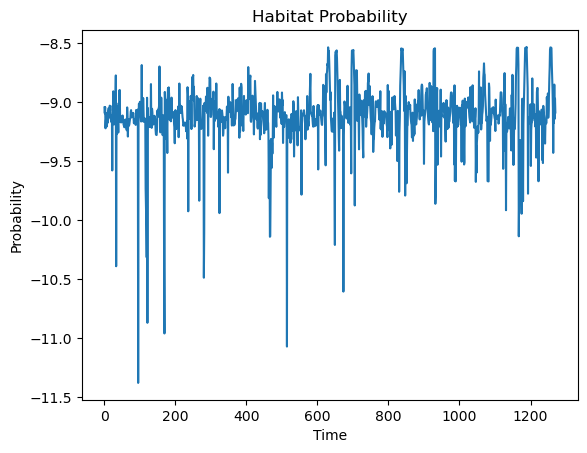

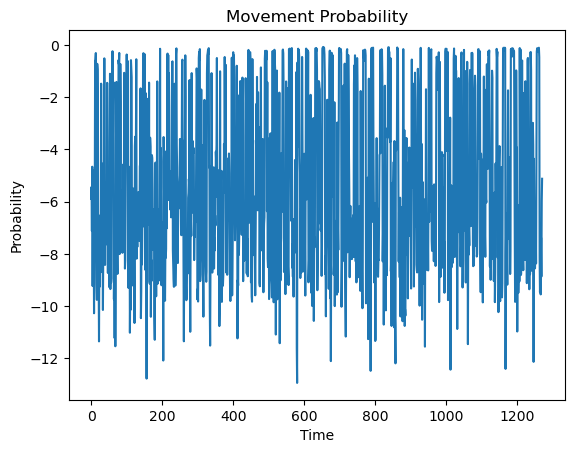

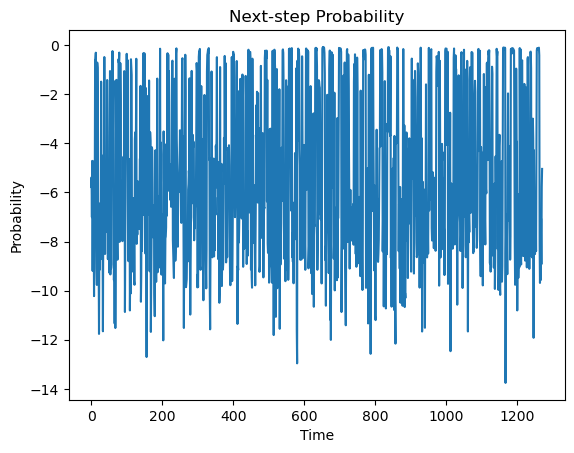

In [25]:
# Plot the habitat probs through time as a line graph
plt.plot(np.log(habitat_probs[habitat_probs>0]))
plt.xlabel('Time')
plt.ylabel('Probability')
plt.title('Habitat Probability')
plt.show()

# Plot the movement probs through time as a line graph
plt.plot(np.log(move_probs[move_probs>0]))
plt.xlabel('Time')
plt.ylabel('Probability')
plt.title('Movement Probability')
plt.show()

# Plot the next_step probs through time as a line graph
plt.plot(np.log(next_step_probs[next_step_probs>0]))
plt.xlabel('Time')
plt.ylabel('Probability')
plt.title('Next-step Probability')
plt.show()


In [71]:
# Append the probabilities to the dataframe
buffalo_df['habitat_probs'] = habitat_probs
buffalo_df['move_probs'] = move_probs
buffalo_df['next_step_probs'] = next_step_probs

In [72]:
csv_filename = f'../outputs/next_step_probs_TAmix_id{buffalo_id}_{today_date}.csv'

print(csv_filename)
# buffalo_df.to_csv(csv_filename, index=True)

../outputs/next_step_probs_TAmix_id2387_2024-12-06.csv


# Loop the validation over each individual

In [26]:
# select the id to train the model on
# buffalo_id = 2005
# n_samples = 10297

# buffalo_id = 2014
# n_samples = 6572

# buffalo_id = 2327
# n_samples = 8983

# buffalo_id = 2387
# n_samples = 10409

# Specify the path to your CSV file
csv_file_path = f'../buffalo_local_data_id/validation/validation_buffalo_{buffalo_id}_data_df_lag_1hr_n{n_samples}.csv'

# Read the CSV file into a DataFrame
buffalo_df = pd.read_csv(csv_file_path)

# Display the first few rows of the DataFrame
print(buffalo_df.head())

# Lag the values in column 'A' by one index
buffalo_df['bearing_tm1'] = buffalo_df['bearing'].shift(1)
# Pad the missing value with a specified value, e.g., 0
buffalo_df['bearing_tm1'] = buffalo_df['bearing_tm1'].fillna(0)

# Display the first few rows of the DataFrame
print(buffalo_df.head())

             x_            y_                    t_    id           x1_  \
0  41969.310875 -1.435671e+06  2018-07-25T01:04:23Z  2005  41969.310875   
1  41921.521939 -1.435654e+06  2018-07-25T02:04:39Z  2005  41921.521939   
2  41779.439594 -1.435601e+06  2018-07-25T03:04:17Z  2005  41779.439594   
3  41841.203272 -1.435635e+06  2018-07-25T04:04:39Z  2005  41841.203272   
4  41655.463332 -1.435604e+06  2018-07-25T05:04:27Z  2005  41655.463332   

            y1_           x2_           y2_     x2_cent    y2_cent  ...  \
0 -1.435671e+06  41921.521939 -1.435654e+06  -47.788936  16.857110  ...   
1 -1.435654e+06  41779.439594 -1.435601e+06 -142.082345  53.568427  ...   
2 -1.435601e+06  41841.203272 -1.435635e+06   61.763677 -34.322938  ...   
3 -1.435635e+06  41655.463332 -1.435604e+06 -185.739939  31.003534  ...   
4 -1.435604e+06  41618.651923 -1.435608e+06  -36.811409  -4.438037  ...   

         ta    cos_ta         x_min         x_max         y_min         y_max  \
0  1.367942  0.20

In [27]:
# Step 1: Specify the directory containing your TIFF files
data_dir = '../buffalo_local_data_id/validation'  # Replace with the actual path to your TIFF files

# Step 2: Use glob to get a list of all TIFF files matching the pattern
csv_files = glob.glob(os.path.join(data_dir, 'validation_*.csv')) 
print(f'Found {len(csv_files)} CSV files')
print('\n'.join(csv_files))

# select only 2005
csv_files = [csv_files[0]]
print(csv_files)

Found 13 CSV files
../buffalo_local_data_id/validation\validation_buffalo_2005_data_df_lag_1hr_n10297.csv
../buffalo_local_data_id/validation\validation_buffalo_2014_data_df_lag_1hr_n6572.csv
../buffalo_local_data_id/validation\validation_buffalo_2018_data_df_lag_1hr_n9440.csv
../buffalo_local_data_id/validation\validation_buffalo_2021_data_df_lag_1hr_n6928.csv
../buffalo_local_data_id/validation\validation_buffalo_2022_data_df_lag_1hr_n9099.csv
../buffalo_local_data_id/validation\validation_buffalo_2024_data_df_lag_1hr_n9531.csv
../buffalo_local_data_id/validation\validation_buffalo_2039_data_df_lag_1hr_n5569.csv
../buffalo_local_data_id/validation\validation_buffalo_2154_data_df_lag_1hr_n10417.csv
../buffalo_local_data_id/validation\validation_buffalo_2158_data_df_lag_1hr_n9700.csv
../buffalo_local_data_id/validation\validation_buffalo_2223_data_df_lag_1hr_n5310.csv
../buffalo_local_data_id/validation\validation_buffalo_2327_data_df_lag_1hr_n8983.csv
../buffalo_local_data_id/validati

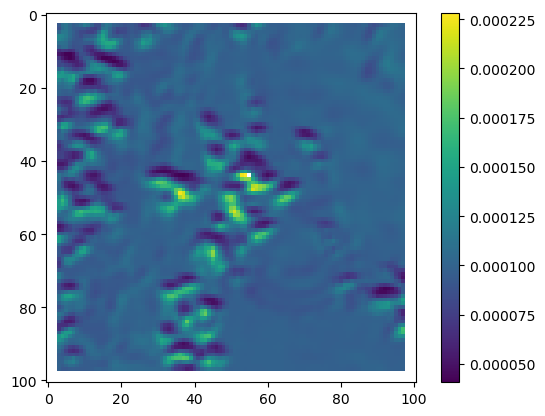

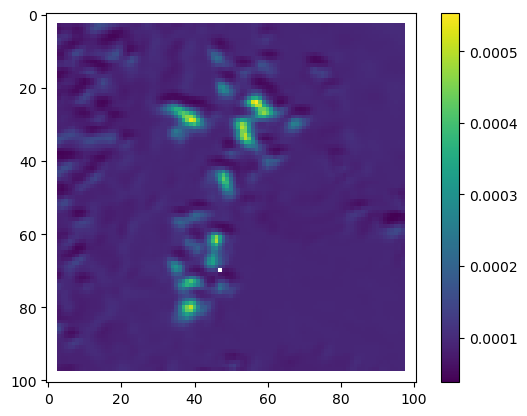

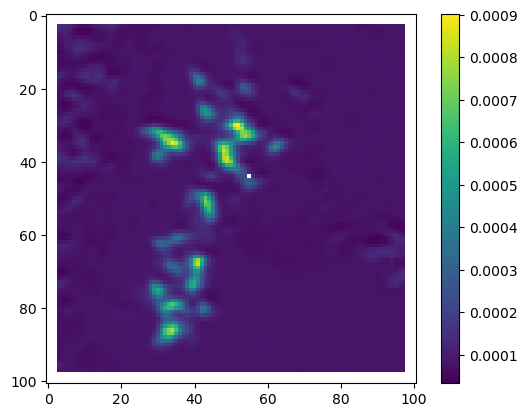

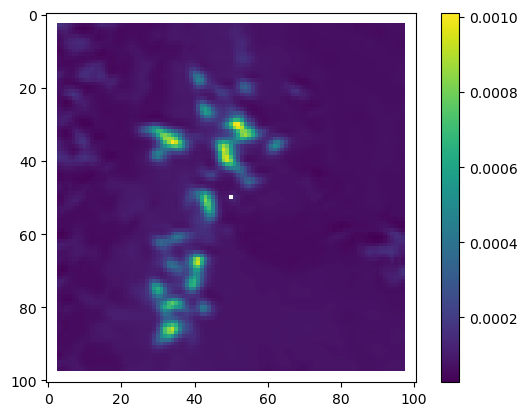

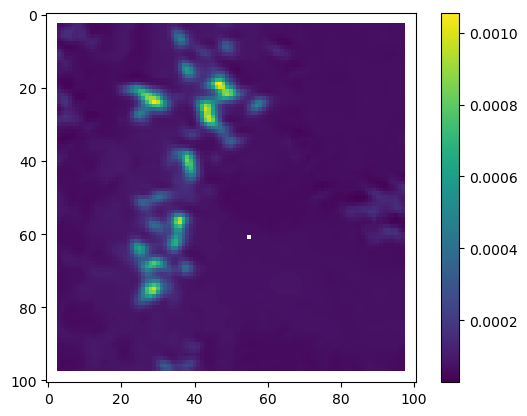

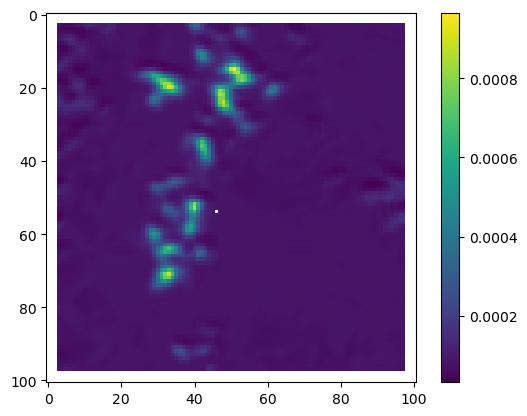

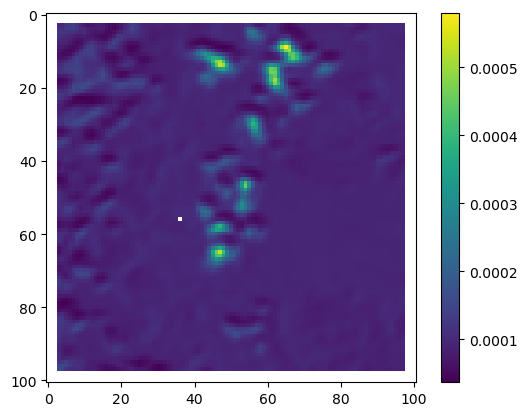

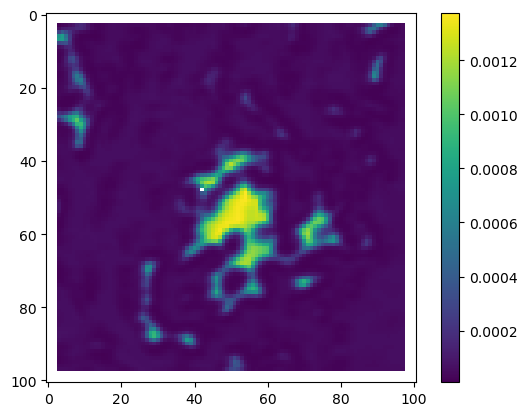

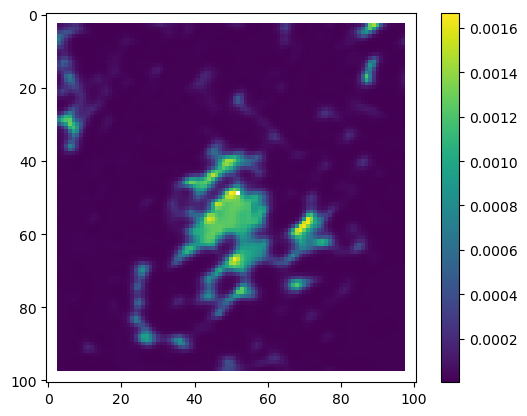

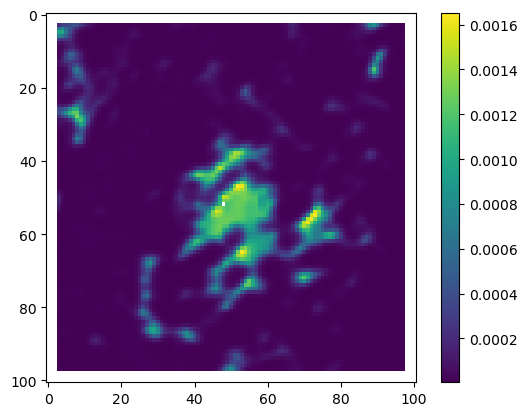

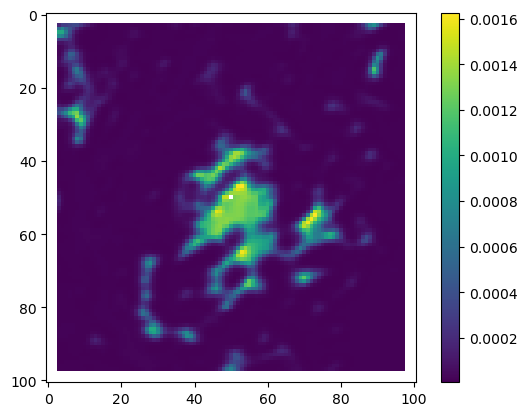

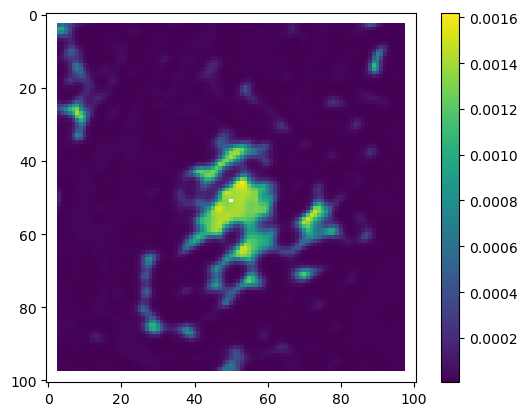

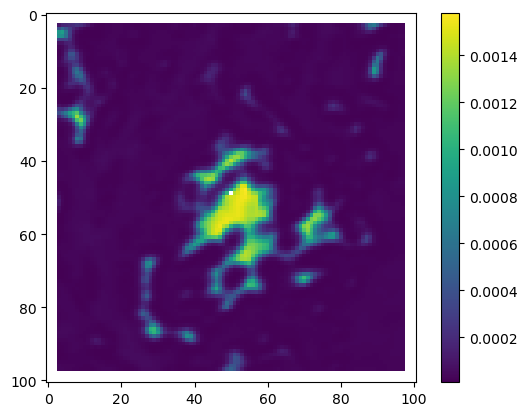

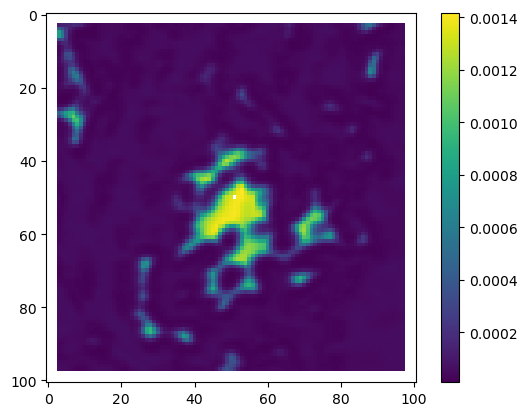

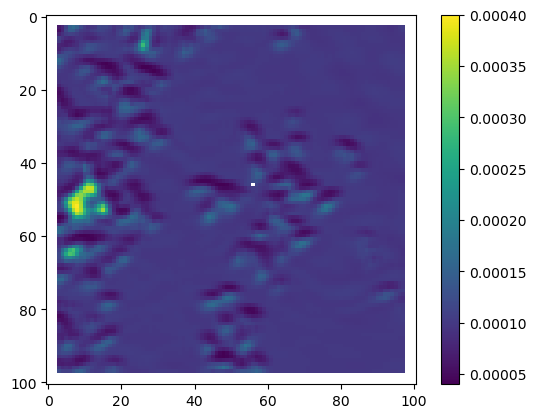

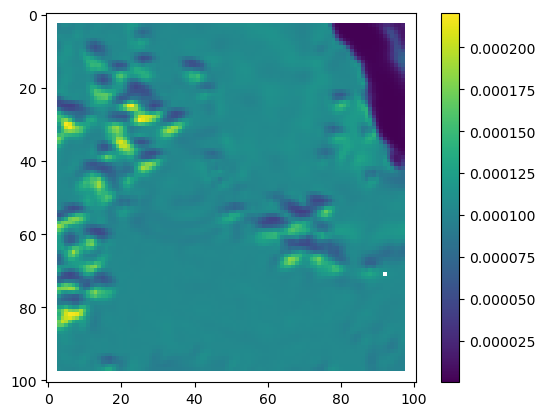

KeyboardInterrupt: 

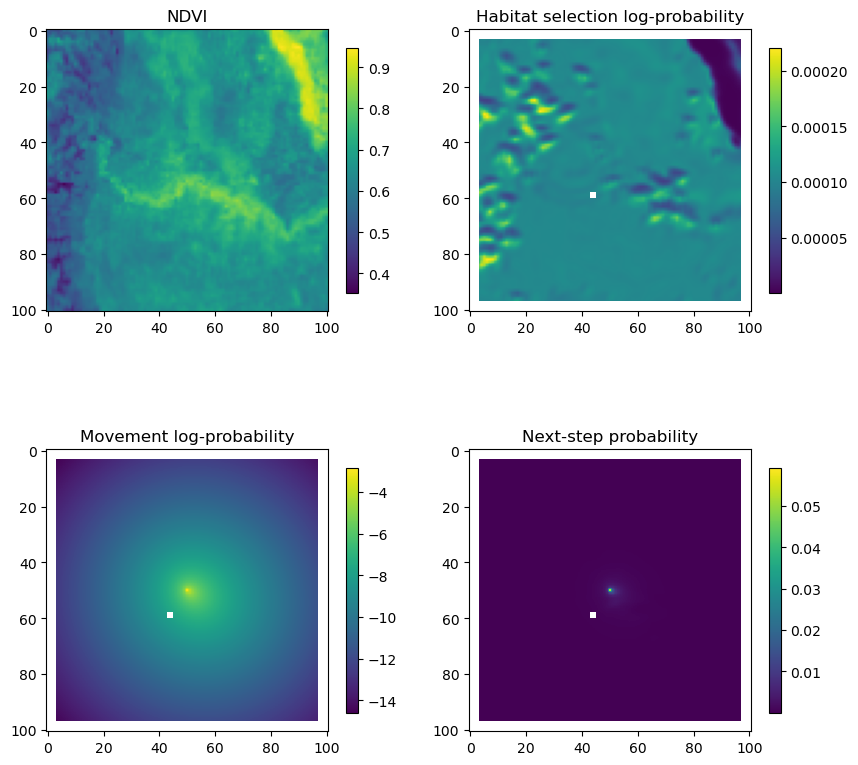

In [34]:
for j in range(0, len(csv_files)):

    # Read the CSV file into a DataFrame
    buffalo_df = pd.read_csv(csv_files[j])

    # for saving the file
    buffalo_id = csv_files[j][55:59]

    # Display the first few rows of the DataFrame
    # print(buffalo_df.head())

    # Lag the values in column 'A' by one index
    buffalo_df['bearing_tm1'] = buffalo_df['bearing'].shift(1)
    # Pad the missing value with a specified value, e.g., 0
    buffalo_df['bearing_tm1'] = buffalo_df['bearing_tm1'].fillna(0)

    test_data = buffalo_df.iloc[7000:7500]
    # test_data = buffalo_df
    n = len(test_data)

    # create empty vectors to store the predicted probabilities
    habitat_probs = np.repeat(0., len(buffalo_df))
    move_probs = np.repeat(0., len(buffalo_df))
    next_step_probs = np.repeat(0., len(buffalo_df))

    # start at 1 so the bearing at t - 1 is available
    for i in range(1, n):
    
        sample_tm1 = test_data.iloc[i-1] # get the step at t - 1 for the bearing of the approaching step
        sample = test_data.iloc[i]

        # current location (x1, y1)
        x = sample['x1_']
        y = sample['y1_']
        # print('x and y are ', x,y)

        # Convert geographic coordinates to pixel coordinates
        px, py = ~raster_transform * (x, y)
        # Convert geographic coordinates to pixel coordinates
        # new_x, new_y = raster_transform * (px, py)
        # print('px and py are ', px, py)

        # next step location (x2, y2)
        x2 = sample['x2_']
        y2 = sample['y2_']
        # print('x2 and y2 are ', x2, y2)

        # Convert geographic coordinates to pixel coordinates
        px2, py2 = ~raster_transform * (x2, y2)
        # print('px2 and py2 are ', px2, py2)


        # # THE Y COORDINATE COMES FIRST in the sampled coordinates
        # new_px = origin_xs[0] + sampled_coordinates[1]
        # new_py = origin_ys[0] + sampled_coordinates[0]

        # # Convert geographic coordinates to pixel coordinates
        # new_x, new_y = raster_transform * (new_px, new_py)

        d_x = x2 - x
        d_y = y2 - y
        # print('d_x and d_y are ', d_x, d_y)
        

        # temporal covariates
        hour_t2_sin = sample['hour_t2_sin']
        hour_t2_cos = sample['hour_t2_cos']
        yday_t2_sin = sample['yday_t2_sin']
        yday_t2_cos = sample['yday_t2_cos']
        # print(hour_t2_sin, hour_t2_cos, yday_t2_sin, yday_t2_cos)

        hour_t2_integer = int(sample['hour_t2'])

        # bearing of PREVIOUS step
        bearing = sample_tm1['bearing']
        # print(bearing)

        yday = sample['yday_t2_2018_base']
        # yday = sample['yday_t2']
        # print(yday)
        yday_t2_integer = int(yday)

        month_index = day_to_month_index(yday)
        # print(month_index)

        ndvi_subset, origin_x, origin_y = subset_raster_with_padding_torch(ndvi_global_norm[month_index,:,:], x, y, window_size, raster_transform)
        canopy_subset, origin_x, origin_y = subset_raster_with_padding_torch(canopy_global_norm, x, y, window_size, raster_transform)
        herby_subset, origin_x, origin_y = subset_raster_with_padding_torch(herby_global_norm, x, y, window_size, raster_transform)
        slope_subset, origin_x, origin_y = subset_raster_with_padding_torch(slope_global_norm, x, y, window_size, raster_transform)

        # print('origin_x and origin_y are ', origin_x, origin_y)

        px2_subset = px2 - origin_x
        py2_subset = py2 - origin_y
        # print('delta origin_x and origin_y are ', px2_subset, py2_subset)
        # print('delta origin_x and origin_y are ', int(px2_subset), int(py2_subset))

        # Extract the value of the covariates at the location of x2, y2
        value = ndvi_subset.detach().cpu().numpy()[(int(py2_subset), int(px2_subset))]

        # # from the stack of local layers
        # ndvi_max = 0.8220
        # ndvi_min = -0.2772
        # # return to natural scale
        # value_natural = value * (ndvi_max - ndvi_min) + ndvi_min

        # print('Value natural scale = ', value_natural)
        

        # # Plot the subset covariates
        # fig_covs, axs_covs = plt.subplots(2, 2, figsize=(10, 10))

        # # NDVI
        # axs_covs[0, 0].imshow(ndvi_subset.numpy(), cmap='viridis')
        # axs_covs[0, 0].set_title('NDVI')
        # fig_covs.colorbar(axs_covs[0, 0].imshow(ndvi_subset.numpy(), cmap='viridis'), ax=axs_covs[0, 0], shrink=0.7)
        # # Canopy Cover
        # axs_covs[0, 1].imshow(canopy_subset.numpy(), cmap='viridis')
        # axs_covs[0, 1].set_title('Canopy Cover')
        # fig_covs.colorbar(axs_covs[0, 1].imshow(canopy_subset.numpy(), cmap='viridis'), ax=axs_covs[0, 1], shrink=0.7)
        # # Herbaceous Vegetation
        # axs_covs[1, 0].imshow(herby_subset.numpy(), cmap='viridis')
        # axs_covs[1, 0].set_title('Herbaceous Vegetation')
        # fig_covs.colorbar(axs_covs[1, 0].imshow(herby_subset.numpy(), cmap='viridis'), ax=axs_covs[1, 0], shrink=0.7)
        # # Slope
        # axs_covs[1, 1].imshow(slope_subset.numpy(), cmap='viridis')
        # axs_covs[1, 1].set_title('Slope')  
        # fig_covs.colorbar(axs_covs[1, 1].imshow(slope_subset.numpy(), cmap='viridis'), ax=axs_covs[1, 1], shrink=0.7)


        # Stack the channels along a new axis; here, 1 is commonly used for channel axis in PyTorch
        x1 = torch.stack([ndvi_subset, canopy_subset, herby_subset, slope_subset], dim=0)
        x1 = x1.unsqueeze(0)
        # print(x1.shape)

        # Convert lists to PyTorch tensors
        hour_t2_sin_tensor = torch.tensor(hour_t2_sin).float()
        hour_t2_cos_tensor = torch.tensor(hour_t2_cos).float()
        yday_t2_sin_tensor = torch.tensor(yday_t2_sin).float()
        yday_t2_cos_tensor = torch.tensor(yday_t2_cos).float()

        # Stack tensors column-wise
        x2 = torch.stack((hour_t2_sin_tensor.unsqueeze(0), 
                            hour_t2_cos_tensor.unsqueeze(0), 
                            yday_t2_sin_tensor.unsqueeze(0), 
                            yday_t2_cos_tensor.unsqueeze(0)),  
                            dim=1)
        # print(x2)
        # print(x2.shape)

        # put bearing in the correct dimension (batch_size, 1)
        bearing = torch.tensor(bearing).float().unsqueeze(0).unsqueeze(0)
        # print(bearing)
        # print(bearing.shape)

        test = model((x1, x2, bearing))

        # plot the results of the habitat density as an image
        hab_density = test.detach().cpu().numpy()[0,:,:,0]
        hab_density_exp = np.exp(hab_density)
        # print(np.sum(hab_density_exp))

        # Store the probability of habitat selection at the location of x2, y2
        habitat_probs[i] = hab_density_exp[(int(py2_subset), int(px2_subset))]
        # print('Habitat probability value = ', habitat_probs[i])

        # Create the mask for x and y coordinates
        x_mask = np.ones_like(hab_density)
        y_mask = np.ones_like(hab_density)

        # mask out cells on the edges that affect the colour scale
        x_mask[:, :3] = -np.inf
        x_mask[:, 98:] = -np.inf
        y_mask[:3, :] = -np.inf
        y_mask[98:, :] = -np.inf

        hab_density_mask = hab_density * x_mask * y_mask
        hab_density_exp_mask = hab_density_exp * x_mask * y_mask

        # # plot the results of the habitat density as an image - in log scale
        # plt.imshow(hab_density_mask)
        # plt.colorbar()
        # plt.show()

        # plot the results of the habitat density as an image - as probabilities
        plt.imshow(hab_density_exp_mask * next_step_mask)
        plt.colorbar()
        plt.show()

        # movement probability
        move_density = test.detach().cpu().numpy()[0,:,:,1]
        move_density_exp = np.exp(move_density)
        # print(np.sum(move_density_exp))

        # Store the probability of movement at the location of x2, y2
        move_probs[i] = move_density_exp[(int(py2_subset), int(px2_subset))]
        # print('Movement probability value = ', move_probs[i])

        move_density_mask = move_density * x_mask * y_mask
        move_density_exp_mask = move_density_exp * x_mask * y_mask

        # # plot the results of the movement density as an image - in log scale
        # plt.imshow(move_density_mask)
        # plt.colorbar()
        # plt.show()

        # # plot the results of the movement density as an image - as probabilities
        # plt.imshow(move_density_exp_mask)
        # plt.colorbar()
        # plt.show()

        # next step probability
        step_density = test[0, :, :, 0] + test[0, :, :, 1]
        step_density = step_density.detach().cpu().numpy()
        step_density_exp = np.exp(step_density)
        # print('Sum of step density exp = ', np.sum(step_density_exp))

        step_density_exp_norm = step_density_exp / np.sum(step_density_exp)
        # print('Sum of step density exp norm = ', np.sum(step_density_exp_norm))

        # Extract the value of the covariates at the location of x2, y2
        next_step_probs[i] = step_density_exp_norm[(int(py2_subset), int(px2_subset))]
        # print('Next-step probability value = ', next_step_probs[i])

        step_density_mask = step_density * x_mask * y_mask
        step_density_exp_norm_mask = step_density_exp_norm * x_mask * y_mask

        # # results of the habitat and movement densities
        # # log-scale
        # plt.imshow(step_density_mask)
        # plt.colorbar()
        # plt.show()

        # # exponentiated
        # plt.imshow(step_density_exp_mask)
        # plt.colorbar()
        # plt.show()

        # [(int(py2_subset), int(px2_subset))]
        next_step_mask = np.ones_like(hab_density)
        next_step_mask[int(py2_subset), int(px2_subset)] = -np.inf


        # Plot the outputs
        fig_out, axs_out = plt.subplots(2, 2, figsize=(10, 10))

        # Plot NDVI
        im1 = axs_out[0, 0].imshow(ndvi_subset.numpy(), cmap='viridis')
        axs_out[0, 0].set_title('NDVI')
        fig_out.colorbar(im1, ax=axs_out[0, 0], shrink=0.7)

        # # Plot target
        # im2 = axs[0, 1].imshow(labels.detach().cpu().numpy()[0,:,:], cmap='viridis')
        # axs[0, 1].set_title('Observed next step')
        # # fig.colorbar(im2, ax=axs[0, 1], shrink=0.7)

        # # Plot slope
        # im2 = axs[0, 1].imshow(x1.detach().cpu().numpy()[0,12,:,:], cmap='viridis')
        # axs[0, 1].set_title('Slope')
        # fig.colorbar(im2, ax=axs[0, 1], shrink=0.7)

        # # Plot habitat selection log-probability
        # im2 = axs_out[0, 1].imshow(hab_density_mask * next_step_mask, cmap='viridis')
        # axs_out[0, 1].set_title('Habitat selection log-probability')
        # fig_out.colorbar(im2, ax=axs_out[0, 1], shrink=0.7)

        # Plot habitat selection probability
        im2 = axs_out[0, 1].imshow(hab_density_exp_mask * next_step_mask, cmap='viridis')
        axs_out[0, 1].set_title('Habitat selection log-probability')
        fig_out.colorbar(im2, ax=axs_out[0, 1], shrink=0.7)

        # Movement density log-probability
        im3 = axs_out[1, 0].imshow(move_density_mask * next_step_mask, cmap='viridis')
        axs_out[1, 0].set_title('Movement log-probability')
        fig_out.colorbar(im3, ax=axs_out[1, 0], shrink=0.7)

        # # Next-step log probability
        # im4 = axs[1, 1].imshow(step_density_mask, cmap='viridis')
        # axs[1, 1].set_title('Next-step log-probability')
        # fig.colorbar(im4, ax=axs[1, 1], shrink=0.7)

        

        # Next-step probability
        im4 = axs_out[1, 1].imshow(step_density_exp_norm_mask * next_step_mask, cmap='viridis')
        axs_out[1, 1].set_title('Next-step probability')
        fig_out.colorbar(im4, ax=axs_out[1, 1], shrink=0.7)

        filename_covs = f'outputs/next_step_validation/id{buffalo_id}_yday{yday_t2_integer}_hour{hour_t2_integer}.png'
        plt.tight_layout()
        plt.savefig(filename_covs, dpi=600, bbox_inches='tight')
        # plt.show()
        plt.close()  # Close the figure to free memory

        
    # Plot the habitat probs through time as a line graph
    plt.plot(np.log(habitat_probs[habitat_probs>0]))
    plt.xlabel('Time')
    plt.ylabel('Probability')
    plt.title('Habitat Probability')
    plt.show()

    # Plot the movement probs through time as a line graph
    plt.plot(np.log(move_probs[move_probs>0]))
    plt.xlabel('Time')
    plt.ylabel('Probability')
    plt.title('Movement Probability')
    plt.show()

    # Plot the next_step probs through time as a line graph
    plt.plot(np.log(next_step_probs[next_step_probs>0]))
    plt.xlabel('Time')
    plt.ylabel('Probability')
    plt.title('Next-step Probability')
    plt.show()

    # Append the probabilities to the dataframe
    buffalo_df['habitat_probs'] = habitat_probs
    buffalo_df['move_probs'] = move_probs
    buffalo_df['next_step_probs'] = next_step_probs
    csv_filename = f'../outputs/next_step_probs_TAmix_id{buffalo_id}_{today_date}.csv'

    print(csv_filename)
    # buffalo_df.to_csv(csv_filename, index=True)

In [32]:
value = -7.5
print(np.exp(value))

value = 6e-4
print(np.log(value))

# buffalo_df

0.0005530843701478336
-7.418580902748128


# Distance and bearing layers

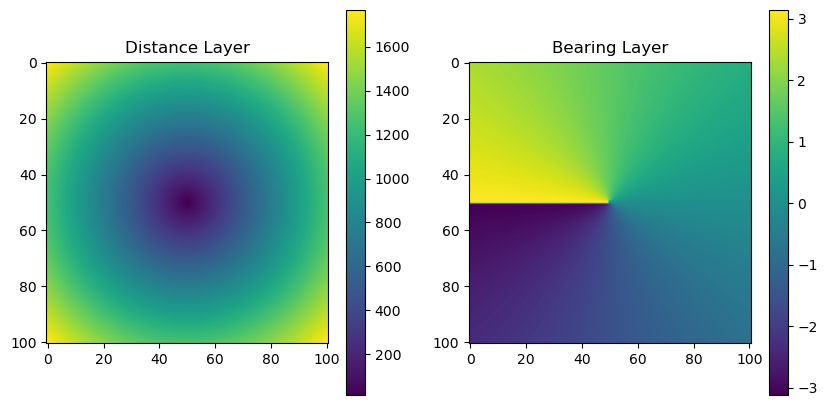

In [ ]:
image_dim = 101
pixel_size = 25
center = image_dim // 2
y, x = np.indices((image_dim, image_dim))

distance_layer = np.sqrt((pixel_size*(x - center))**2 + (pixel_size*(y - center))**2)
# change the centre cell to the average distance from the centre to the edge of the pixel
distance_layer[center, center] = 0.56*pixel_size # average distance from the centre to the perimeter of the pixel (accounting for longer distances at the corners)
bearing_layer = np.arctan2(center - y, x - center)

# plot both of the layers
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(distance_layer)
ax[0].set_title('Distance Layer')
# add colour scale
cbar = plt.colorbar(ax[0].imshow(distance_layer), ax=ax[0])
ax[1].imshow(bearing_layer)
ax[1].set_title('Bearing Layer')
# add colour scale
cbar = plt.colorbar(ax[1].imshow(bearing_layer), ax=ax[1])
plt.show()
